# 1.1 Setup a Folder:

---






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
if not os.path.isdir("Covid19"):
  os.makedirs("Covid19")
%cd Covid19

/content/drive/MyDrive/Covid19


## 1.2 Donwloading DataSet:

---





In [ ]:
!pip install opendatasets
import opendatasets as od
if not os.path.isdir("covid19-chest-xray-image-dataset"):
  od.download("https://www.kaggle.com/datasets/alifrahman/covid19-chest-xray-image-dataset")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedghida
Your Kaggle Key: ··········


100%|██████████| 40.6M/40.6M [00:01<00:00, 21.8MB/s]


## 2.1 Exploring & Visualize The Data:

---






In [ ]:
for directory in (os.listdir('covid19-chest-xray-image-dataset/dataset')):
      print(f"The Number Of {directory} Images: "+str(len((os.listdir(f'covid19-chest-xray-image-dataset/dataset/{directory}')))))

The Number Of covid Images: 69
The Number Of normal Images: 25


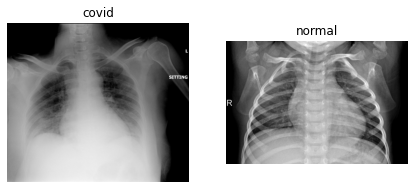

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
for number,folder in enumerate(os.listdir('covid19-chest-xray-image-dataset/dataset')):
  names=os.listdir('covid19-chest-xray-image-dataset/dataset/'+folder)
  indx=np.random.randint(len(names))
  img=plt.imread(f"covid19-chest-xray-image-dataset/dataset/{folder}/{str(names[indx])}")
  plt.subplot(1,4,number+1)
  plt.imshow(img,cmap="gray")
  plt.title(str(folder))
  plt.axis('off')

splitting data


In [ ]:
covid=os.listdir("covid19-chest-xray-image-dataset/dataset/covid")
normal=os.listdir("covid19-chest-xray-image-dataset/dataset/normal")
x,y=[],[]
for i in covid:
  x.append(i)
  y.append(1)
for i in normal:
  x.append(i)
  y.append(0)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.1,shuffle=True)

In [ ]:
import shutil as sh 
from tqdm import tqdm

for i in tqdm(x):
  if i in covid:
    folder='covid'
  else:
    folder='normal'
  if i in xtrain:
    path2save='Train'
  else:
    path2save='Test'
  if not os.path.exists(f"covid19-chest-xray-image-dataset/{path2save}/{folder}"):
         os.makedirs(f"covid19-chest-xray-image-dataset/{path2save}/{folder}")
  sh.move(f"covid19-chest-xray-image-dataset/dataset/{folder}/{i}",f"covid19-chest-xray-image-dataset/{path2save}/{folder}/{i}")  

sh.rmtree("covid19-chest-xray-image-dataset/dataset")
print("****File named dataset was deleted****")

100%|██████████| 94/94 [00:00<00:00, 391.08it/s]

****File named dataset was deleted****


##2.2 Data Augmentation & Loading :
---


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
Size=150
B_size=4
Training_path='covid19-chest-xray-image-dataset/Train'
train_datagen=ImageDataGenerator(rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)
train_generator=train_datagen.flow_from_directory(Training_path,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 84 images belonging to 2 classes.


(-0.5, 149.5, 149.5, -0.5)

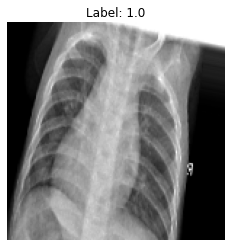

In [ ]:
#Viz Data From Generator
Image,Y=next(train_generator)
plt.imshow(Image[0],cmap="gray")
plt.title("Label: "+str(Y[0]))
plt.axis('off')

# 3.1 Loading The Model:

---
we will make Transfer Learning from Pneumonia Model Classification
That Will Helps.
https://colab.research.google.com/drive/18G9oYcIhnQl_7N7rCaOLuOvgXzQWQnq3?usp=sharing

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
model=load_model("/content/drive/MyDrive/Pneumonia/pnemonia.hdf5")
#freezing layers:
for layer in model.layers[:-5]:
  layer.trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 148, 148, 64)     137       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 146, 146, 64)     4736      
 leConv2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_2 (Separab  (None, 71, 71, 32)       2656      
 leConv2D)                                                       
                                                                 
 separable_conv2d_3 (Separab  (None, 69, 69, 32)       1

In [ ]:
#model compilation:
model.compile(optimizer ="adam",loss='binary_crossentropy',metrics= ['accuracy', Precision(name='percesion'),Recall(name='recall')])

# 3.2 Trainning:

---


In [ ]:
epoch=100
steps=int(len(train_generator))
history=model.fit(train_generator,
                  epochs=epoch,
                  steps_per_epoch=steps)

Epoch 1/100
11/11 [==============================] - 5s 219ms/step - loss: 1.6163 - accuracy: 0.5000 - percesion: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 3s 222ms/step - loss: 0.8212 - accuracy: 0.6786 - percesion: 0.3000 - recall: 0.1304
Epoch 3/100
11/11 [==============================] - 3s 229ms/step - loss: 0.6915 - accuracy: 0.6786 - percesion: 0.1667 - recall: 0.0435
Epoch 4/100
11/11 [==============================] - 3s 259ms/step - loss: 0.6015 - accuracy: 0.7143 - percesion: 0.4444 - recall: 0.1739
Epoch 5/100
11/11 [==============================] - 3s 235ms/step - loss: 0.5590 - accuracy: 0.7500 - percesion: 0.5833 - recall: 0.3043
Epoch 6/100
11/11 [==============================] - 3s 246ms/step - loss: 0.4808 - accuracy: 0.8095 - percesion: 0.8182 - recall: 0.3913
Epoch 7/100
11/11 [==============================] - 3s 236ms/step - loss: 0.4524 - accuracy: 0.8452 - percesion: 0.7778 - recall: 0.6087
Epoch 8/100
11/11 [=======

# 3.3 Evaluating & Predicting:

---


In [ ]:
Testing_path='covid19-chest-xray-image-dataset/Test'
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(Testing_path,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 10 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator,steps=len(test_generator))

2/2 [==============================] - 1s 79ms/step - loss: 0.0163 - accuracy: 1.0000 - percesion: 1.0000 - recall: 1.0000


[0.016311723738908768, 1.0, 1.0, 1.0]

In [ ]:
model.save("Covid19.hdf5")